In [ ]:
%cd /src/code
from typing import Dict, Any, List, Optional, Union
import subprocess
import hashlib
import os
import logging
import json
import random
import time
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
from hyperopt import hp
from hyperopt.pyll import scope
from hyperopt import space_eval

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import mlflow
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

from libs import (
    PandasStandardScaler,
    PandasPCA,
    RemoveUncorrelated,
    calculate_params_hash,
    train_model,
    objective
)

random.seed(42)
logging.basicConfig(level=logging.INFO)
pd.set_option('display.max_columns', None)
api = KaggleApi()
api.authenticate()

target_col: str = 'failure_prone'

/src/code


In [3]:
X = pd.read_csv('../assets/X_train.csv', index_col='id')
y = pd.read_csv('../assets/y_train.csv', index_col='id')[target_col].astype(int)

print(X.shape)
print(X.info())
X.head()

(159090, 108)
<class 'pandas.core.frame.DataFrame'>
Index: 159090 entries, 0 to 159089
Columns: 108 entries, additions to delta_text_entropy
dtypes: float64(94), int64(14)
memory usage: 132.3 MB
None


,additions,additions_avg,additions_max,avg_play_size,avg_task_size,change_set_avg,change_set_max,code_churn_avg,code_churn_count,code_churn_max,commits_count,contributors_count,deletions,deletions_avg,deletions_max,highest_contributor_experience,hunks_median,lines_blank,lines_code,lines_comment,minor_contributors_count,num_authorized_key,num_block_error_handling,num_blocks,num_commands,num_conditions,num_decisions,num_deprecated_keywords,num_deprecated_modules,num_distinct_modules,num_external_modules,num_fact_modules,num_file_exists,num_file_mode,num_file_modules,num_filters,num_ignore_errors,num_import_playbook,num_import_role,num_import_tasks,num_include,num_include_role,num_include_tasks,num_include_vars,num_keys,num_lookups,num_loops,num_math_operations,num_names_with_vars,num_parameters,num_paths,num_plays,num_prompts,num_regex,num_roles,num_suspicious_comments,num_tasks,num_tokens,num_unique_names,num_uri,num_vars,text_entropy,delta_avg_play_size,delta_avg_task_size,delta_lines_blank,delta_lines_code,delta_lines_comment,delta_num_authorized_key,delta_num_block_error_handling,delta_num_blocks,delta_num_commands,delta_num_conditions,delta_num_decisions,delta_num_deprecated_keywords,delta_num_deprecated_modules,delta_num_distinct_modules,delta_num_external_modules,delta_num_fact_modules,delta_num_file_exists,delta_num_file_mode,delta_num_file_modules,delta_num_filters,delta_num_ignore_errors,delta_num_import_playbook,delta_num_import_role,delta_num_import_tasks,delta_num_include,delta_num_include_role,delta_num_include_tasks,delta_num_include_vars,delta_num_keys,delta_num_lookups,delta_num_loops,delta_num_math_operations,delta_num_names_with_vars,delta_num_parameters,delta_num_paths,delta_num_plays,delta_num_prompts,delta_num_regex,delta_num_roles,delta_num_suspicious_comments,delta_num_tasks,delta_num_tokens,delta_num_unique_names,delta_num_uri,delta_num_vars,delta_text_entropy
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0.0,10.0,2,27,0,0,0,0,0,0,0,0,0.0,0.0,8.0,87.0,5.0,0,0.0,0.0,0.0,5.0,9.0,5.0,1.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,5.0,0.0,1.0,17.0,5.0,0.0,0.0,0.0,0.0,0.0,9.0,293.0,11.0,0.0,1.0,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0.0,6.0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,24.0,103.0,59.0,0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,87.0,0.0,1.0,0.0,0.0,25.0,6.0,0.0,0.0,0.0,0.0,0.0,16.0,238.0,17.0,0.0,3.0,6.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0.0,4.0,2,12,0,0,0,0,0,0,0,0,0.0,0.0,1.0,8.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,22.0,2.0,0.0,1.0,4.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0.0,6.0,1,4,0,0,0,0,0,0,0,0,0.0,0.0,5.0,33.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,28.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,109.0,8.0,0.0,1.0,5.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0.0,4.0,1,2,0,0,0,0,0,0,0,0,0.0,0.0,1.0,9.0,12.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0,2.0,0.0,0.0,4.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Search experiment by param hash in the UI: http://localhost:5001/#/experiments/127862172636814249?searchFilter=params.hyperparameters_hash+%3D"93e4fd814e77e84921d23bc536a84566"


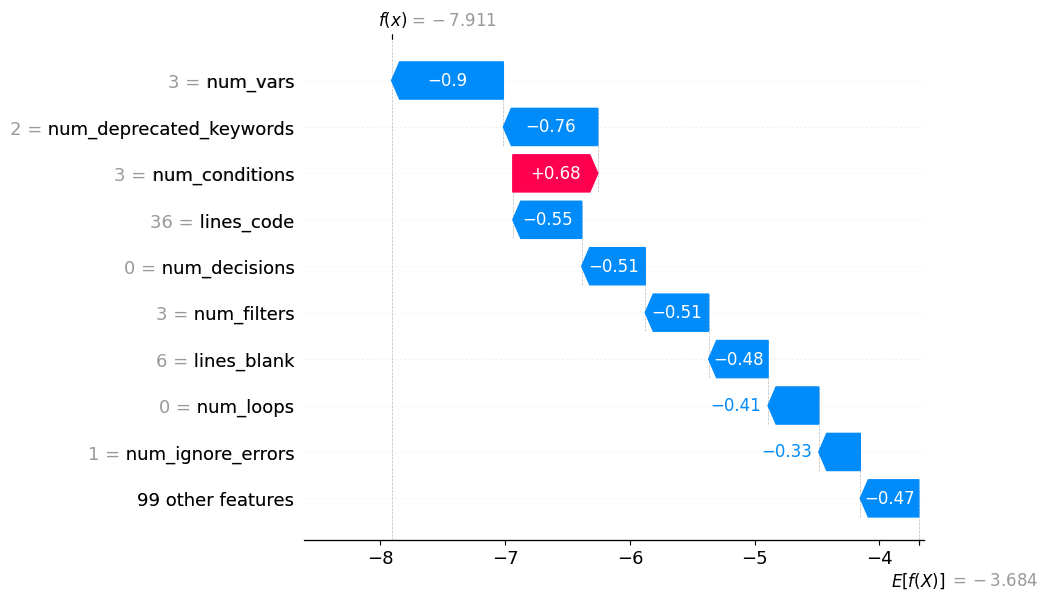

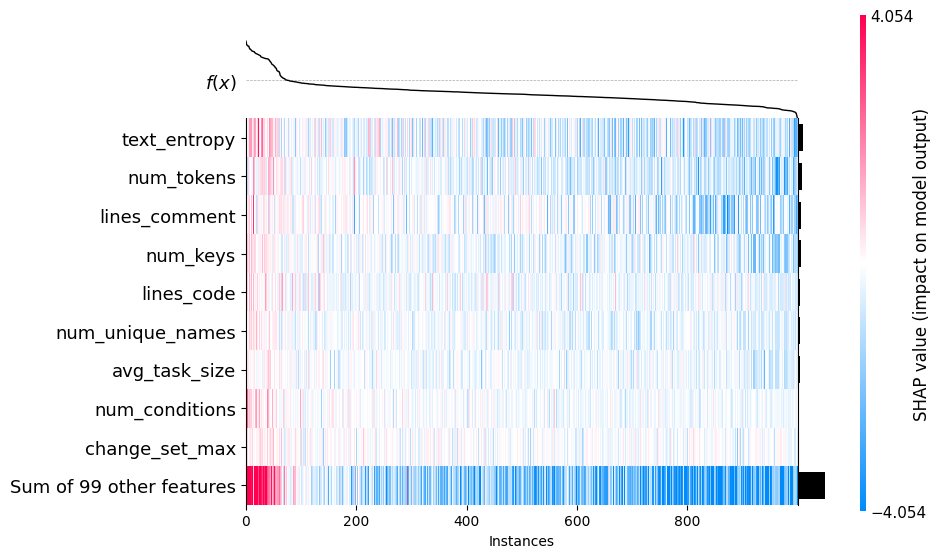

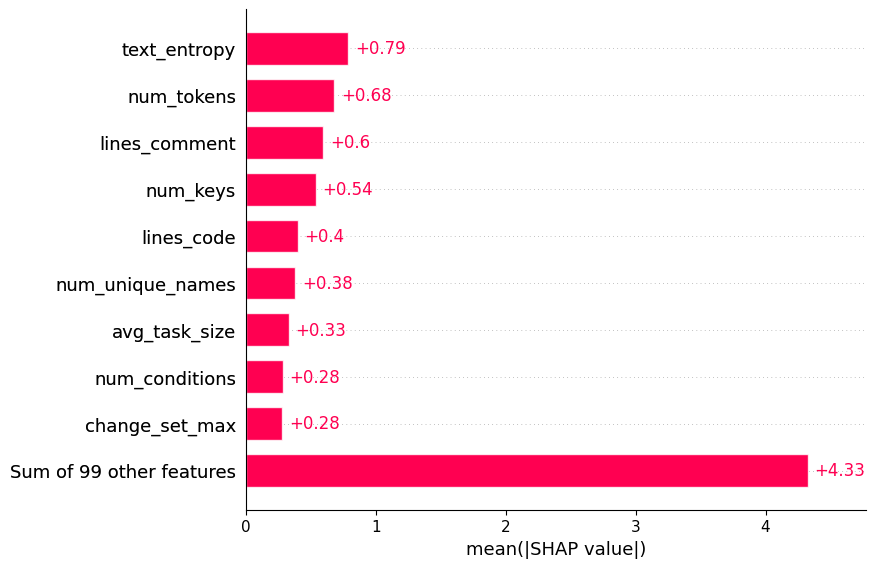

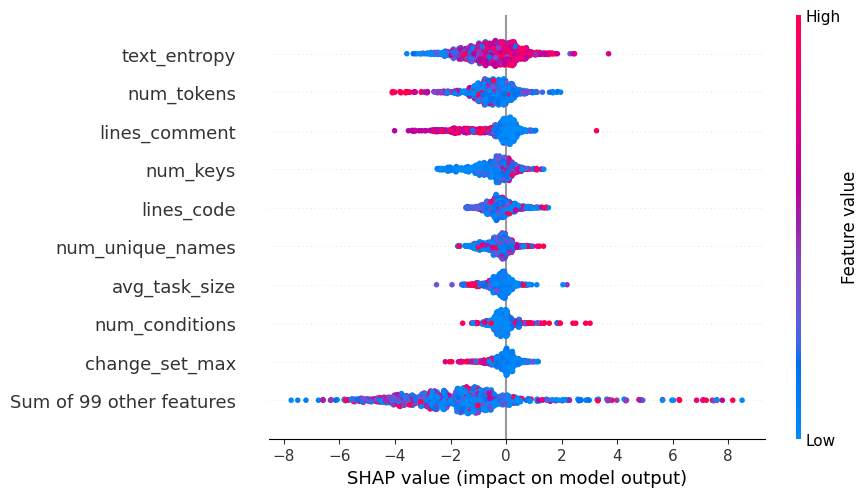

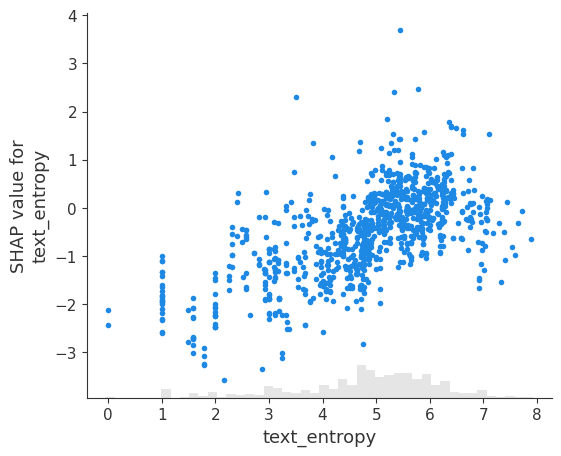

CPU times: user 26min 52s, sys: 15.6 s, total: 27min 8s
Wall time: 9min 13s


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4928067035150168, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=0, ...))])

In [5]:
%%time
best_hyperparameters = {'framework': 'xgboost~=2.1', 'learning_rate': 0.4928067035150168, 'max_depth': 10, 'model': XGBClassifier, 'n_estimators': 200, 'random_state': 0}
best_hash = calculate_params_hash(best_hyperparameters)
print(f'Search experiment by param hash in the UI: http://localhost:5001/#/experiments/127862172636814249?searchFilter=params.hyperparameters_hash+%3D"{best_hash}"')

model = train_model(best_hyperparameters, X, y, analyze=True)
model